In [1]:
import torch
print(torch.cuda.is_available())		 # 查看GPu设备是否可用
print(torch.cuda.device_count()) 		# 查看GPu设备数量
print(torch.cuda.get_device_name())   	# 查看当前GPu设备名称，默认设备id从0开始
print(torch.cuda.current_device())		# 查看当前GPu设备id


ModuleNotFoundError: No module named 'torch'

In [1]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main#exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict

# fix_seed = 2021 
# random.seed(fix_seed)
# torch.manual_seed(fix_seed)
# np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')#模型id
parser.add_argument('--model', type=str, required=True, default='Autoformer',#选择模型
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')#数据类型
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')#数据文件夹路径
parser.add_argument('--data_path', type=str, default='TaTrach.csv', help='data file')#具体文件
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')#不太懂 OT好像代表Output Target,要预测的单变量
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')#保存模型

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')#输入序列长度
parser.add_argument('--label_len', type=int, default=48, help='start token length')#这个label_len未完全搞懂
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')#输出序列长度

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')#输出长度
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads 
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')#窗口滑动平均数
parser.add_argument('--factor', type=int, default=1, help='attn factor')#attn factor不太理解
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)#是否在encoder里面使用知识蒸馏
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding不太能get到
parser.add_argument('--activation', type=str, default='gelu', help='activation')#激活函数default=gelu
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')#encoder的output_attention是否输出
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')#是否预测未见的未来数据,也就是是否进行推理的意思

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# num_workers是加载数据(batch)的线程数目
parser.add_argument('--itr', type=int, default=2, help='experiments times')#实验次数
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience: 当early stop被激活(如发现loss相比上一个epoch训练没有下降)，则经过patience个epoch后停止训练
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#使用自动混合精度训练

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'OT'
args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #是否使用多卡的判断
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.seq_len = 4
args.label_len = 4
args.pred_len = 1
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 1
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.distil = True
args.output_attention = False
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 32 
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'

args.train_epochs = 2
args.is_training = True
args.enc_in = 5
args.dec_in = 5
args.c_out = 5
args.target = "luuluongden"
args.root_path = './dataset/'
args.data_path ='Data_TaTrach.csv' 
args.model_id='TaTrach_96_24'
# args.model = 'Autoformer'
args.model = 'Informer'
args.data = 'custom'
args.features = 'MS'

print('Args in experiment:')
print(args)



Exp = Exp_Main


Args in experiment:
{'target': 'luuluongden', 'des': 'Exp', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'seq_len': 4, 'label_len': 4, 'pred_len': 1, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 1, 'd_model': 512, 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 3, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 2, 'is_training': True, 'enc_in': 5, 'dec_in': 5, 'c_out': 5, 'root_path': './dataset/', 'data_path': 'Data_TaTrach.csv', 'model_id': 'TaTrach_96_24', 'model': 'Informer', 'data': 'custom', 'features': 'MS'}


In [2]:
if args.is_training:
  for ii in range(args.itr):
      # setting record of experiments
      setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
          args.model_id,
          args.model,
          args.data,
          args.features,
          args.seq_len,
          args.label_len,
          args.pred_len,
          args.d_model,
          args.n_heads,
          args.e_layers,
          args.d_layers,
          args.d_ff,
          args.factor,
          args.embed,
          args.distil,
          args.des, ii)

      exp = Exp(args)  # set experiments
      print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
      exp.train(setting)

      print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
      exp.test(setting)

      if args.do_predict:
          print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
          exp.predict(setting, True)

      torch.cuda.empty_cache()
else:
  ii = 0
  setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(args.model_id,
                                                                                                args.model,
                                                                                                args.data,
                                                                                                args.features,
                                                                                                args.seq_len,
                                                                                                args.label_len,
                                                                                                args.pred_len,
                                                                                                args.d_model,
                                                                                                args.n_heads,
                                                                                                args.e_layers,
                                                                                                args.d_layers,
                                                                                                args.d_ff,
                                                                                                args.factor,
                                                                                                args.embed,
                                                                                                args.distil,
                                                                                                args.des, ii)

  exp = Exp(args)  # set experiments
  print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
  exp.test(setting, test=1)
  torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : TaTrach_96_24_Informer_custom_ftMS_sl4_ll4_pl1_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 38519
val 5505
test 11006
	iters: 100, epoch: 1 | loss: 0.0264492
	speed: 0.2628s/iter; left time: 606.2881s
	iters: 200, epoch: 1 | loss: 0.0640357
	speed: 0.0324s/iter; left time: 71.5891s
	iters: 300, epoch: 1 | loss: 0.2790504
	speed: 0.0317s/iter; left time: 66.7460s
	iters: 400, epoch: 1 | loss: 0.0160619
	speed: 0.0311s/iter; left time: 62.4886s
	iters: 500, epoch: 1 | loss: 0.3001421
	speed: 0.0319s/iter; left time: 60.8608s
	iters: 600, epoch: 1 | loss: 0.0221572
	speed: 0.0318s/iter; left time: 57.5041s
	iters: 700, epoch: 1 | loss: 0.0172639
	speed: 0.0299s/iter; left time: 50.9702s
	iters: 800, epoch: 1 | loss: 0.0606139
	speed: 0.0307s/iter; left time: 49.4101s
	iters: 900, epoch: 1 | loss: 0.0488893
	speed: 0.0319s/iter; left time: 48.0774s
	iters: 1000, epoch: 1 | loss: 0.0189330
	speed: 0.0302s/iter; lef

In [ ]:
exp.test(setting)

test 11006
test shape: (11006, 1, 1) (11006, 1, 1)
test shape: (11006, 1, 1) (11006, 1, 1)
mse:0.18992836773395538, mae:0.13872060179710388, r2:0.9264846295118332


In [ ]:
import numpy as np

setting = "TaTrach_96_24_Autoformer_custom_ftMS_sl4_ll4_pl1_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0"

pred_path = 'results/' + format(setting) + '/pred.npy'
pred_data = np.load(pred_path)
pred_data = pred_data.reshape(pred_data.shape[0])


true_path = 'results/' + format(setting) + '/true.npy'
true_data = np.load(true_path)
true_data = true_data.reshape(true_data.shape[0])


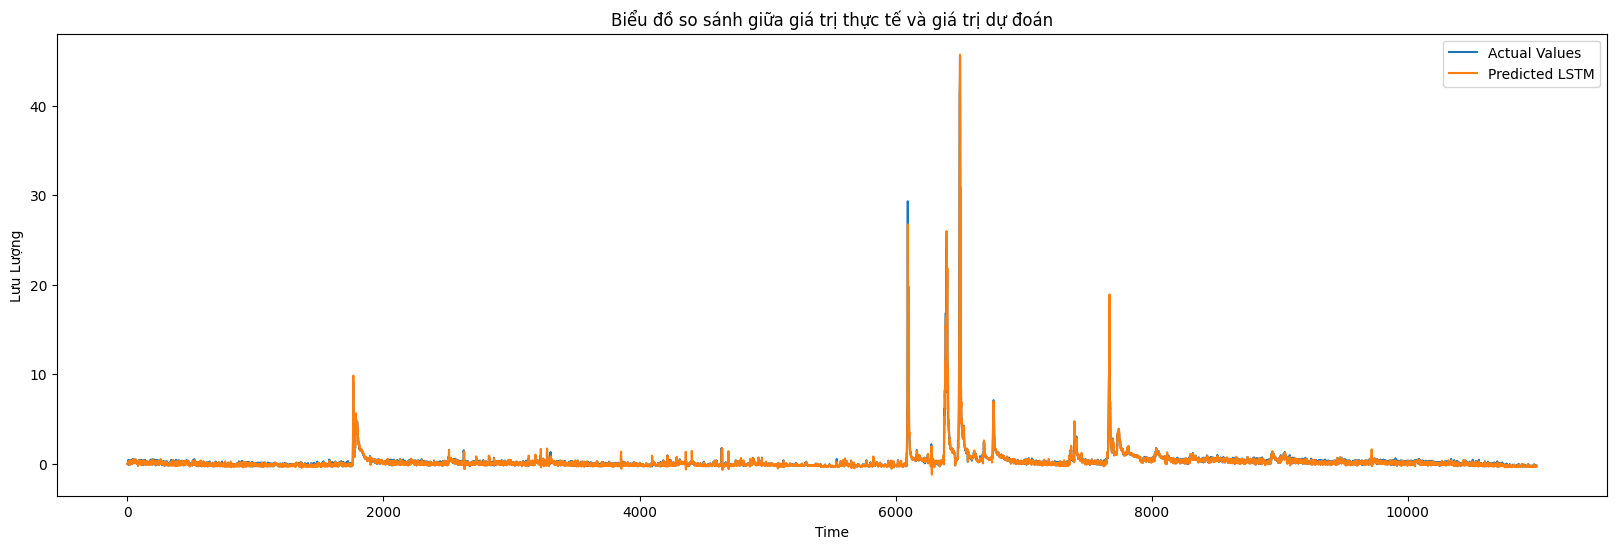

In [ ]:
from matplotlib import pyplot #vẽ biểu đồ

pyplot.figure(figsize=(20,6))

pyplot.plot(true_data, label='Actual Values')
pyplot.plot(pred_data, label='Predicted LSTM')
pyplot.title('Biểu đồ so sánh giữa giá trị thực tế và giá trị dự đoán')
pyplot.xlabel('Time')
pyplot.ylabel('Lưu Lượng')
pyplot.legend()
pyplot.show()

In [16]:
pred_data, pred_loader = exp._get_data(flag='pred')
pred_data.data_x


pred 1


array([[-0.13961663, -0.34535078, -0.12616195, -0.15095965, -0.2574459 ],
       [-0.13961663, -0.34535078, -0.12616195, -0.15095965, -0.31524795],
       [-0.13961663, -0.34535078, -0.12616195, -0.15095965, -0.32176381],
       [-0.13961663, -0.34535078, -0.12616195, -0.15095965, -0.25749845]])

In [18]:
pred_data.inverse_transform()

TypeError: inverse_transform() missing 1 required positional argument: 'data'